# Inversion example of the diffusion

- Import required packages

In [1]:
import os
import logging
import copy
from pathlib import Path
from typing import Generator
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection
from matplotlib.animation import HTMLWriter
from IPython.display import HTML
import nested_grid_plotter as ngp
import pyrtid
import pyrtid.forward as dmfwd
import pyrtid.inverse as dminv
import numpy as np
import scipy as sp

- Check package/software versions

In [2]:
pyrtid.utils.show_versions()

- Create a directory to store the exported figures

In [27]:
ipynb_path = os.path.dirname(os.path.realpath("__file__"))
fig_save_path = Path(ipynb_path, "exported_figures")
fig_save_path.mkdir(parents=True, exist_ok=True)  # make sure that the directory exists

- Set-up logging level

In [28]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.info("this is a test")

INFO:root:this is a test


- Define some configurations for the plots

In [29]:
# Some configs for the plots
new_rc_params = {
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica", "DejaVu Sans"],
    "font.size": 16,
    "text.usetex": False,
    "savefig.format": "svg",
    "svg.fonttype": "none",  # to store text as text, not as path
    "savefig.facecolor": "w",
    "savefig.edgecolor": "k",
    "savefig.dpi": 300,
    "figure.constrained_layout.use": True,
    "figure.facecolor": "w",
    "axes.facecolor": "w",
}
csfont = {"fontname": "Comic Sans MS"}
hfont = {"fontname": "Helvetica"}
plt.plot()
plt.close()  # required for the plot to update
plt.rcParams.update(new_rc_params)

## Forward problem

Let's define a very simple pure diffusion case in 1D.

In [30]:
time_params = dmfwd.TimeParameters(
    duration=duration_in_s, dt_init=dt_init, dt_max=dt_max, dt_min=dt_min
)
geometry = dmfwd.Geometry(nx=20, ny=1, dx=2.5, dy=2.5)
fl_params = dmfwd.FlowParameters(
    permeability=2.0e-3,
    storage_coefficient=2.0,
    regime=dmfwd.FlowRegime.TRANSIENT,
    crank_nicolson=1.0,
)


# We define a function to easily generate a model.
def create_base_model() -> dmfwd.ForwardModel:
    return dmfwd.ForwardModel(geometry, time_params, fl_params)

- x_coordinates array for the plots

In [31]:
x_coordinates = (np.arange(geometry.nx) + 0.5) * geometry.dx

- Time for the plots

In [32]:
times_in_hours = np.arange(time_params.nt) * time_params.dt / 3600  # in hours

- Create two identical model

In [33]:
model_reference = create_base_model()
model_estimate = create_base_model()

- The reference has a "bumped" permeability field, while the initial estimate is more smooth.

In [34]:
model_reference.fl_model.permeability[5:-5, 0] = 1.0e-2
model_estimate.fl_model.permeability = sp.ndimage.gaussian_filter(
    model_reference.fl_model.permeability, 4.0
)

The head field is zero except at the boundary with constant heads

In [35]:
model_reference.fl_model.head[0] = 10.0  # m
model_reference.fl_model.head[-1] = 4.0  # m
left_bc = dmfwd.
ConstantHead((slice(0, 1), slice(None)))
right_bc = dmfwd.
ConstantHead((slice(geometry.nx - 1, geometry.nx), slice(None)))
model_reference.add_boundary_conditions(right_bc)
model_reference.add_boundary_conditions(left_bc)

model_estimate.fl_model.head[0] = 10.0  # m
model_estimate.fl_model.head[-1] = 4.0  # m
model_estimate.add_boundary_conditions(right_bc)
model_estimate.add_boundary_conditions(left_bc)

- Plot it

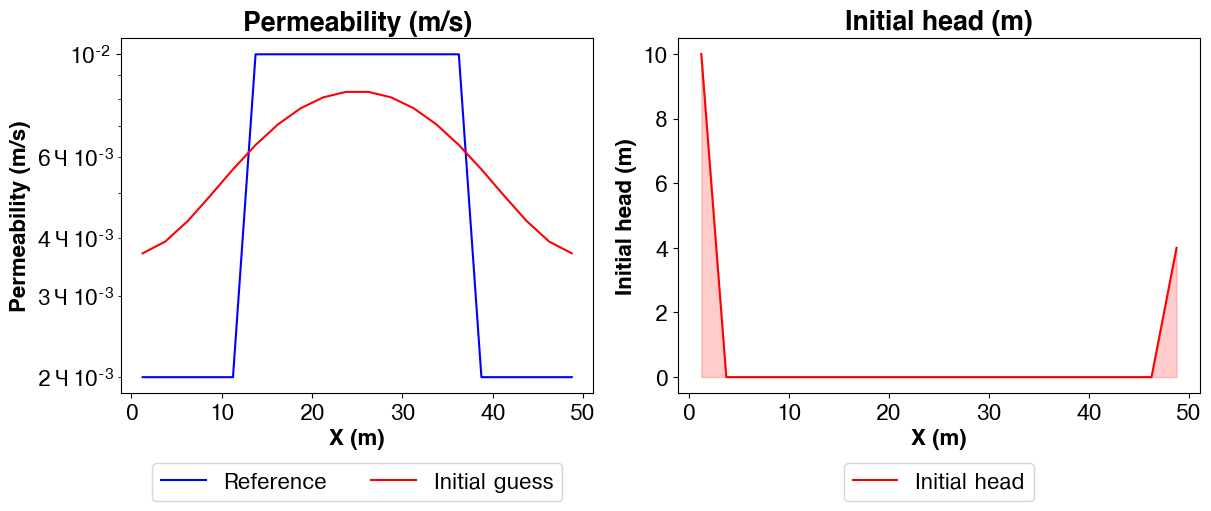

In [36]:
plotter = ngp.NestedGridPlotter(
    fig_params={"figsize": (12, 5)}, subfigs_params={"ncols": 2}
)
ax1 = plotter.ax_dict["ax1-1"]
ax1.plot(
    x_coordinates, model_reference.fl_model.permeability[:, 0], label="Reference", c="b"
)
ax1.plot(
    x_coordinates,
    model_estimate.fl_model.permeability[:, 0],
    label="Initial guess",
    c="r",
)
ax1.set_yscale("log")
ax1.legend(ncol=2, loc="center", bbox_to_anchor=(0.5, -0.25))
ax1.set_xlabel("X [m]", fontweight="bold")
ax1.set_ylabel("Permeability (m/s)", fontweight="bold")
ax1.set_title("Permeability (m/s)", fontweight="bold")

ax2 = plotter.ax_dict["ax1-2"]
ax2.plot(
    x_coordinates,
    model_reference.fl_model.head[:, 0, 0],
    label="Initial head",
    color="red",
)
ax2.fill_between(
    x_coordinates,
    0.0,
    model_reference.fl_model.head[:, 0, 0],
    alpha=0.2,
    color="red",
)
ax2.set_xlabel("X [m]", fontweight="bold")
ax2.set_ylabel("Initial head [m]", fontweight="bold")
ax2.set_title("Initial head [m]", fontweight="bold")
ax2.legend(loc="center", bbox_to_anchor=(0.5, -0.25))
plotter.fig.patch.set_facecolor("w")

fname = "initial_head_and_permeability"
for format in ["png", "pdf"]:
    plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)

We can then run these too models and compare the results

In [37]:
solver_reference = dmfwd.
ForwardSolver(model_reference)
solver_reference.solve()

In [38]:
solver_estimate = dmfwd.
ForwardSolver(model_estimate)
solver_estimate.solve()

We can disply the results in different ways.

- Top view

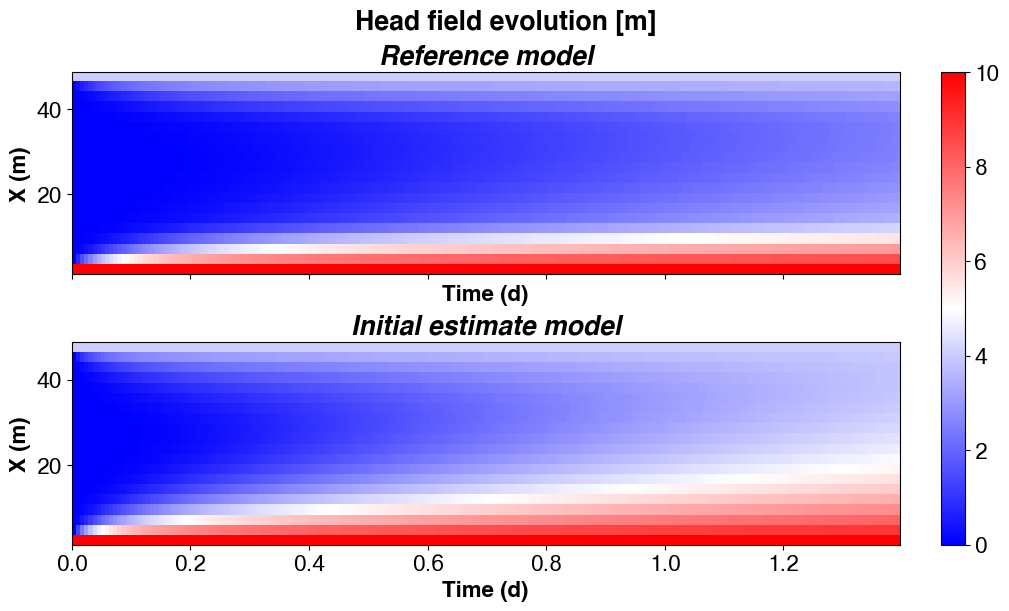

In [39]:
plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (10, 6)},
    subplots_mosaic_params={
        "fig0": dict(
            mosaic=[["ax1-1"], ["ax2-1"]],
            sharey=True,
            sharex=True,
        )
    },
)

ngp.multi_imshow(
    axes=list(plotter.ax_dict.values()),
    fig=plotter.fig,
    data={
        "Reference model": solver_reference.model.fl_model.head[:, 0, :].T,
        "Initial estimate model": solver_estimate.model.fl_model.head[:, 0, :].T,
    },
    xlabel="Time (d)",
    ylabel="X [m]",
    imshow_kwargs=dict(
        extent=(
            0.0,
            time_params.nt * time_params.dt / 3600 / 24,
            x_coordinates[0],
            x_coordinates[-1],
        )
    ),
)
plotter.fig.suptitle("Head field evolution [m]", fontweight="bold")

fname = "head_reference_vs_estimate_map"
for format in ["png", "pdf"]:
    plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)

- Consider three observation locations

In [40]:
observation_locations = [6, 10, 15]

In [41]:
plotter = ngp.AnimatedPlotter(
    fig_params={"constrained_layout": True, "figsize": (6, 5)},
)

ax = plotter.get_axis("ax1-1")
ax.plot(x_coordinates, model_reference.fl_model.head[:, 0, 0], c="red", label="Initial")

# Animated plot
nb_frames = 30

plotter.animated_multi_plot(
    ax_name="ax1-1",
    data={
        "True": {
            "x": x_coordinates,
            "y": model_reference.fl_model.head[:, 0, :],
            "kwargs": {"c": "blue"},
        },
        "Estimated": {
            "x": x_coordinates,
            "y": model_estimate.fl_model.head[:, 0, :],
            "kwargs": {"c": "green", "linestyle": "--"},
        },
    },
    nb_frames=nb_frames,
    title="Head field evolution [m]",
    xlabel="X [m]",
    ylabel="Head [m]",
)


# plot the time
def get_time() -> Generator[str, None, None]:
    ts_btw_frames = int(time_params.dt * time_params.nt / nb_frames)
    for frame in range(nb_frames):
        yield f"time = {ts_btw_frames * frame / 3600:.2f} h"


# Add some vertical lines to indicate the well
for well_pos in observation_locations:
    # handle = plotter.ax_dict["ax1-1"].axvline(
    #     x=well_pos, linestyle="--", line
    # )
    # plotter.add_extra_legend_item("ax1-1", handle, "hm_end_time")
    ax.plot(
        (well_pos + 0.5) * geometry.dx,
        0.0002,
        label="obs wells",
        marker="^",
        markersize=10,
        c="r",
        linestyle="none",
    )

plotter.plot_animated_text(
    ax=ax,
    x=0.5,
    y=0.92,
    s=list(get_time()),
    horizontalalignment="center",
    verticalalignment="center",
    transform=ax.transAxes,
    fontsize=14,
    fontweight="bold",
)

plotter.add_axis_legend("ax1-1")

plotter.close()
plotter.animate(nb_frames=nb_frames)
# Save the animation locally on the computer
fname_html = fig_save_path.joinpath("head_reference_vs_estimate_map_animation.html")
writer = HTMLWriter(fps=5, embed_frames=True)
writer.frame_format = "svg"  # Ensure svg format
plotter.animation.save(str(fname_html), writer=writer)

# Extract the svg from the html file (for animation in Latex)
ngp.extract_frames_from_embedded_html_animation(fname_html)

# Display the animation
HTML(fname_html.read_text())

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.HTMLWriter'>


- Create a function to add some noise to the observations (limit the inverse crime)

In [42]:
noise_std = 0.3  # This is an absolute value
rng = np.random.default_rng(2021)


def make_noisy(x: NDArrayFloat) -> NDArrayFloat:
    """Return the input with some added white noise.

    Note
    ----
    The parameters are hardcoded to be consistent in the notebook.
    Change the function directly.
    """
    mean_noise = 0.0  # mean
    return x + rng.normal(mean_noise, noise_std, x.shape)

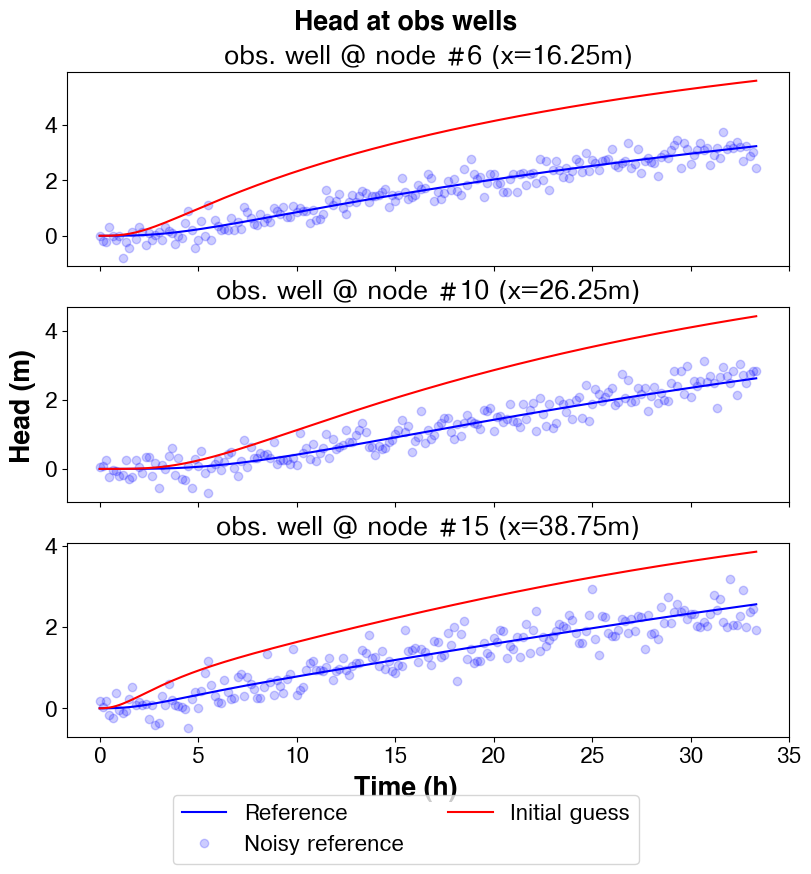

In [43]:
plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (8, 8)},
    subplots_mosaic_params={
        "fig0": dict(
            mosaic=[["ax1-1"], ["ax2-1"], ["ax3-1"]], sharey=False, sharex=True
        )
    },
)

for i, node_id in enumerate(observation_locations):
    ax = plotter.get_axis(f"ax{i + 1}-1")
    x = (node_id + 0.5) * geometry.dx
    obs_well_name = f"obs. well @ node #{node_id} (x={x}m)"

    ax.set_title(obs_well_name)
    ax.plot(
        times_in_hours,
        model_reference.fl_model.head[node_id, 0, :],
        label="Reference",
        c="b",
    )
    ax.plot(
        times_in_hours,
        make_noisy(model_reference.fl_model.head[node_id, 0, :]),
        marker="o",
        linestyle="None",
        label="Noisy reference",
        c="b",
        alpha=0.2,
    )
    ax.plot(
        times_in_hours,
        model_estimate.fl_model.head[node_id, 0, :],
        label="Initial guess",
        c="r",
    )

plotter.fig.supxlabel("Time (h)", fontweight="bold")
plotter.fig.supylabel("Head [m]", fontweight="bold")
plotter.fig.suptitle("Head at obs wells", fontweight="bold")
plotter.add_fig_legend(ncol=2, bbox_y_shift=0.02)

fname = "tracer_concentration_true_vs_estimate_at_obs_1D"
for format in ["png", "pdf"]:
    plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)

## Inversion

### Gradient verification with finite difference

Inversion with three wells. Let's first check if the gradient with ths adjoint state method is correct.

In [44]:
param = AdjustableParameter(
    name=ParameterName.PERMEABILITY,
    lbounds=2e-5,
    ubounds=1e-1,
    preconditioner=dminv.LogTransform(),
)

observables = {}
for node_id in [6, 10, 15]:
    vals = model_reference.fl_model.head[node_id, 0, :]
    timesteps = np.arange(vals.shape[0])

    observables[node_id] = Observable(
        state_variable=StateVariable.HEAD,
        location=(slice(node_id, node_id + 1, 1), slice(None)),
        timesteps=timesteps,
        values=make_noisy(vals),
        uncertainties=noise_std,
    )

# Create an executor to keep track of the adjoint model
solver_config = ScipySolverConfig(
    solver_name="L-BFGS-B",
    solver_options={"maxfun": 20, "maxiter": 20, "ftol": 1e-4, "gtol": 1e-4},
    is_check_gradient=True,
)
model_adjusted = copy.deepcopy(model_estimate)
inverse_model = InverseModel(param, list(observables.values()))
executor = ScipyInversionExecutor(model_adjusted, inverse_model, solver_config)

is_grad_ok = executor.is_adjoint_gradient_correct()
print("Is the gradient correct: ", is_grad_ok)

Is the gradient correct:  True


- Plot the approximated gradient vs the adjoint-state based one

([<matplotlib.lines.Line2D at 0x7f113126f070>,
 ['Adj. Demonstrator', 'FD Demonstrator'])

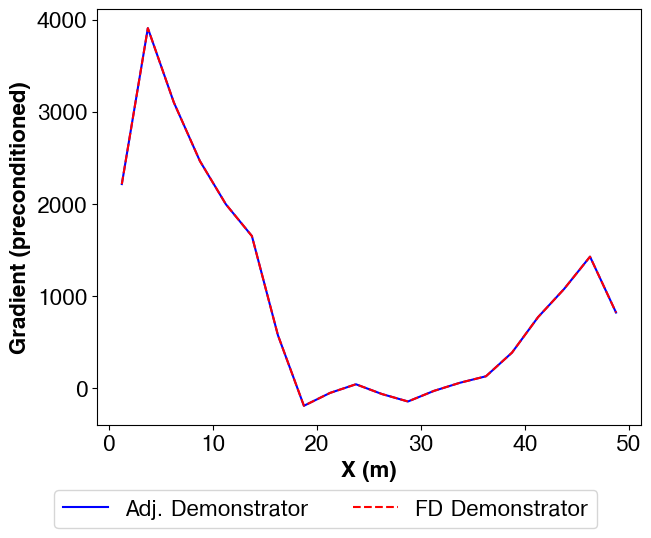

In [45]:
plotter = ngp.NestedGridPlotter()
ax = plotter.get_axis("ax1-1")
ax.plot(
    x_coordinates,
    get_gridded_archived_gradients(param, is_adjoint=True)[:, :, 0],
    label="Adj. Demonstrator",
    c="b",
)
ax.plot(
    x_coordinates,
    get_gridded_archived_gradients(param, is_adjoint=False)[:, :, 0],
    label="FD Demonstrator",
    c="r",
    linestyle="--",
)
ax.set_xlabel("X [m]", fontweight="bold")
ax.set_ylabel("Gradient (preconditioned)", fontweight="bold")
plotter.add_fig_legend(ncol=2)

Plot of the adjoint variables

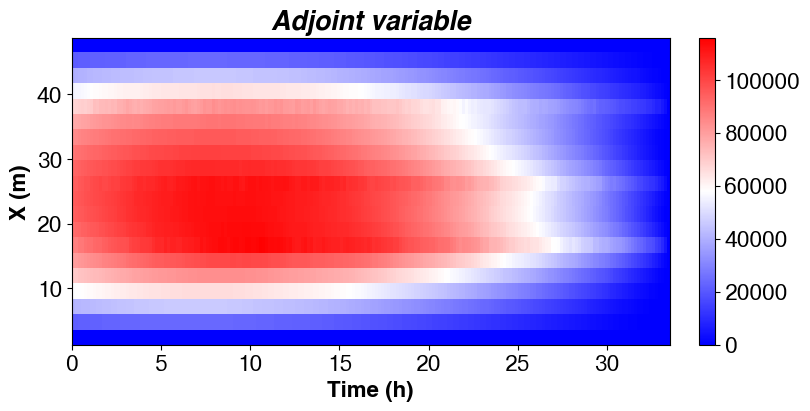

In [46]:
plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (8, 4)}
)

ngp.multi_imshow(
    axes=list(plotter.ax_dict.values()),
    fig=plotter.fig,
    data={
        "Adjoint variable": executor.adj_model.a_fl_model.a_head[:, 0, :].T,
    },
    xlabel="Time (h)",
    ylabel="X [m]",
    imshow_kwargs=dict(
        extent=(
            0.0,
            time_params.nt * time_params.dt / 3600,
            x_coordinates[0],
            x_coordinates[-1],
        )
    ),
)

fname = "tracer_concentration_true_vs_estimate_map"
for format in ["png", "pdf"]:
    plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)

At the observatinon well, we can see that the sign of the adjoint variable globally depends on the sign of the residuals.

In [47]:
plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (12, 8)},
    subfigs_params={"ncols": 2},
    subplots_mosaic_params={
        "fig0": dict(
            mosaic=[["ax1-1"], ["ax2-1"], ["ax3-1"]], sharey=False, sharex=True
        ),
        "fig1": dict(
            mosaic=[["ax1-2"], ["ax2-2"], ["ax3-2"]], sharey=False, sharex=True
        ),
    },
)

for i, node_id in enumerate(observation_locations):
    ax = plotter.get_axis(f"ax{i + 1}-1")
    x = (node_id + 0.5) * geometry.dx
    obs_well_name = f"obs. well @ node #{node_id} (x={x}m)"

    ax.set_title(obs_well_name)
    ax.plot(
        times_in_hours,
        model_reference.fl_model.head[node_id, 0, :],
        label="Reference",
        c="b",
    )
    ax.plot(
        times_in_hours,
        make_noisy(model_reference.fl_model.head[node_id, 0, :]),
        marker="o",
        linestyle="None",
        label="Noisy reference",
        c="b",
        alpha=0.2,
    )
    ax.plot(
        times_in_hours,
        model_estimate.fl_model.head[node_id, 0, :],
        label="Initial guess",
        c="r",
    )

    ax2 = plotter.get_axis(f"ax{i + 1}-2")
    ax2.set_title(obs_well_name)
    ax2.plot(
        times_in_hours,
        executor.adj_model.a_fl_model.a_head[node_id, 0, :],
        label="A priori demonstrator",
        c="r",
    )

plotter.fig.supxlabel("Time (h)", fontweight="bold")
plotter.subfigs["fig0"].supylabel("Concentration (mol/kg)", fontweight="bold")
plotter.subfigs["fig1"].supylabel("Adjoint concentration", fontweight="bold")
plotter.fig.suptitle("Tracer at obs wells", fontweight="bold")
plotter.add_fig_legend(ncol=2, bbox_y_shift=0.02)

fname = "tracer_concentration_true_vs_estimate_at_obs_1D"
for format in ["png", "pdf"]:
    plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)

### First inversion run

In [48]:
executor.run()

INFO:root:============================= Inversion Parameters =============================
INFO:root:Method                                            : L-BFGS-B
INFO:root:
INFO:root:Number of adjusted parameters                     : 1
INFO:root:Number of unknowns (adjusted values)              : 20
INFO:root:Number of observables                             : 3
INFO:root:Number of observation data points (values)        : 603
INFO:root:================================================================================
INFO:root:Entering optimization loop: 1
INFO:root:- Running forward model # 1
INFO:root:- Run # 1 over
INFO:root:Loss (obs fit)        = 6670.7743129574155
INFO:root:Loss (regularization) = 0.0
INFO:root:Scaling factor        = 0.00014990763486895134
INFO:root:Loss (scaled)         = 1.0

INFO:root:- Running gradient # 0
INFO:root:- Gradient eval # 1 over

INFO:root:- Running forward model # 2
INFO:root:- Run # 2 over
INFO:root:Loss (obs fit)        = 1728.9425109593071
IN

      fun: 0.04531836756745571
 hess_inv: <20x20 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 6.94390997e-05,  1.65270320e-04,  6.54933471e-05,  6.37104844e-05,
        7.94115602e-05,  8.49986001e-05, -9.32718815e-04, -1.35583887e-03,
       -1.04159379e-03, -7.70806725e-04, -2.66504302e-04,  3.07318469e-05,
       -1.32004814e-04, -3.21844597e-04, -5.19071148e-04, -3.76427300e-04,
        2.81086141e-05, -5.59573664e-05, -1.32355128e-04, -4.79573705e-05])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 8
      nit: 7
     njev: 8
   status: 0
  success: True
        x: array([-6.13100181, -6.63007631, -6.23246805, -5.91790478, -5.66469888,
       -5.45880229, -5.07669289, -4.82873169, -4.80820808, -4.80079467,
       -4.78523212, -4.79541351, -4.85204023, -4.91840267, -4.99161068,
       -5.28628287, -5.74693226, -6.05020976, -6.4073013 , -6.0279542 ])

Let's plot the results: evolution of the parameter, the gradient, the objective function.

In [50]:
plotter = ngp.AnimatedPlotter(
    fig_params={"figsize": (10.0, 8.0)}, subfigs_params={"nrows": 2, "ncols": 2}
)

# 1 frame per solver iteration
nb_frames: int = inverse_model.nb_f_calls

aligned_adjoint_gradients = get_gridded_archived_gradients(param, is_adjoint=True)

# 1) Gradient evolution
plotter.get_axis("ax1-1").plot(
    aligned_adjoint_gradients[:, 0, 0], label="Initial", c="b"
)

plotter.get_axis("ax1-1").set_title("Gradient", fontweight="bold")

xlabel = "Node #"

plotter.animated_multi_plot(
    ax_name="ax1-1",
    data={
        "ADJ": {"y": aligned_adjoint_gradients[:, 0, :], "kwargs": {"c": "g"}},
    },
    nb_frames=nb_frames,
)

plotter.ax_dict["ax1-1"].legend()


# 2) Parameter evolution
plotter.get_axis("ax1-2").plot(
    x_coordinates, model_reference.fl_model.permeability[:, 0], c="b", label="Reference"
)
plotter.get_axis("ax1-2").plot(
    x_coordinates,
    model_reference.fl_model.permeability[:, 0],
    c="orange",
    label="Initial",
)

plotter.animated_multi_plot(
    ax_name="ax1-2",
    data={
        "Inverted": {
            "x": x_coordinates,
            "y": np.transpose(np.array(param.archived_values), axes=[1, 2, 0])[:, 0, :],
            "kwargs": {"c": "r", "linestyle": "--"},
        },
    },
    nb_frames=nb_frames,
)
plotter.get_axis("ax1-2").set_title("Diffusivity field", fontweight="bold")
plotter.get_axis("ax1-2").set_xlabel("X [m]")
plotter.get_axis("ax1-2").set_ylabel("[m2/s]")
plotter.ax_dict["ax1-2"].legend()
plotter.ax_dict["ax1-2"].set_yscale("log")

# 3) Objective function
vals = inverse_model.loss_scaled_history
obj_fun_vals = np.full((len(vals), nb_frames), fill_value=np.nan)
for i in range(len(vals)):
    obj_fun_vals[: i + 1, i] = vals[: i + 1]

plotter.animated_multi_plot(
    ax_name="ax2-1",
    data={
        "Obj fun": {"y": obj_fun_vals, "kwargs": {"c": "r", "linestyle": "--"}},
    },
    nb_frames=nb_frames,
    title="Objective function",
    xlabel="Iteration #",
)
plotter.ax_dict["ax2-1"].set_yscale("log")

# 4) Observation vs predicted values
pyrtid.plot.plot_observed_vs_simulated(
    plotter.ax_dict["ax2-2"],
    obs_vector=dminv.get_observables_values_as_1d_vector(list(observables.values()))
    * 1000,
    pred_vector=dminv.get_predictions_matching_observations(
        model_adjusted, list(observables.values())
    )
    * 1000,
    pred_vector_initial=dminv.get_predictions_matching_observations(
        model_estimate, list(observables.values())
    )
    * 1000,
    units="$mmol.l^{-1}$",
)

plotter.close()
plotter.animate(nb_frames=nb_frames)
# Save the animation locally on the computer
fname_html = fig_save_path.joinpath("m_j_g_animation.html")
writer = HTMLWriter(fps=2, embed_frames=True)
writer.frame_format = "svg"  # Ensure svg format
plotter.animation.save(str(fname_html), writer=writer)

# Extract the svg from the html file (for animation in Latex)
ngp.extract_frames_from_embedded_html_animation(fname_html)

# Display the animation
HTML(fname_html.read_text())

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.HTMLWriter'>


In [ ]:
plotter = ngp.AnimatedPlotter(
    fig_params={"constrained_layout": True, "figsize": (6, 5)},
)

ax = plotter.get_axis("ax1-1")
ax.plot(x_coordinates, model_reference.fl_model.head[:, 0, 0], c="red", label="Initial")

# Animated plot
nb_frames = 30

plotter.animated_multi_plot(
    ax_name="ax1-1",
    data={
        "Reference": {
            "x": x_coordinates,
            "y": model_reference.fl_model.head[:, 0, :],
            "kwargs": {"c": "blue"},
        },
        "Before-inversion": {
            "x": x_coordinates,
            "y": model_estimate.fl_model.head[:, 0, :],
            "kwargs": {"c": "orange", "linestyle": "--"},
        },
        "Post-inversion": {
            "x": x_coordinates,
            "y": model_adjusted.fl_model.head[:, 0, :],
            "kwargs": {"c": "green", "linestyle": "--"},
        },
    },
    nb_frames=nb_frames,
    title="Demonstrator conc",
    xlabel="X [m]",
)


# plot the time
def get_time() -> Generator[str, None, None]:
    ts_btw_frames = int(time_params.dt * time_params.nt / nb_frames)
    for frame in range(nb_frames):
        yield f"time = {ts_btw_frames * frame / 3600:.2f} h"


# Add some vertical lines to indicate the well
for well_pos in observation_locations:
    # handle = plotter.ax_dict["ax1-1"].axvline(
    #     x=well_pos, linestyle="--", line
    # )
    # plotter.add_extra_legend_item("ax1-1", handle, "hm_end_time")
    ax.plot(
        (well_pos + 0.5) * geometry.dx,
        0.0002,
        label="obs wells",
        marker="^",
        markersize=10,
        c="r",
        linestyle="none",
    )

plotter.plot_animated_text(
    ax=ax,
    x=0.25,
    y=0.92,
    s=list(get_time()),
    horizontalalignment="center",
    verticalalignment="center",
    transform=ax.transAxes,
    fontsize=14,
    fontweight="bold",
)
plotter.add_axis_legend("ax1-1")

plotter.close()
plotter.animate(nb_frames=nb_frames)
# Save the animation locally on the computer
fname_html = fig_save_path.joinpath("true_vs_estimate_conc_animation.html")
writer = HTMLWriter(fps=5, embed_frames=True)
writer.frame_format = "svg"  # Ensure svg format
plotter.animation.save(str(fname_html), writer=writer)

# Extract the svg from the html file (for animation in Latex)
ngp.extract_frames_from_embedded_html_animation(fname_html)

# Display the animation
HTML(fname_html.read_text())